In [ ]:
"""
熱顯像圖片處理流程
一、轉為灰階
二、去噪處理
三、局部增強
#「16-bit 轉 8-bit」(如果有需要) 
四、尺寸縮放
五、標準化/顯示
"""

In [10]:
import cv2
import os
import matplotlib.pyplot as plt

In [11]:
#先讀取資料(照片)，賦值給一個變數
img = cv2.imread('heat_img/heat_img_2.jpg', cv2.IMREAD_UNCHANGED)
#如果單純使用 cv2.imread('heat_img/heat_img_1.jpg') 的話，預設會以 8-bit 格式讀取圖片
#
print(img.dtype)

uint8


In [ ]:
"""cv2.imread('heat_img/heat_img_1.jpg', cv2.IMREAD_UNCHANGED) 第二個參數說明
常數名稱 (Constant),數值,說明與用途
cv2.IMREAD_COLOR, 1  , 預設值。將影像轉為 8-bit BGR 3 通道。即使原圖是灰階也會轉成 BGR。
cv2.IMREAD_GRAYSCALE, 0  , 將影像轉為 8-bit 單通道灰階。常用於特徵檢測、邊緣偵測。
cv2.IMREAD_UNCHANGED, -1  , 原樣讀取。包含 Alpha 通道 (透明度) 以及保留 16-bit/32-bit 深度。
cv2.IMREAD_ANYDEPTH, 2  , 若原圖是 16/32 bit 則保留，若無此標記，OpenCV 會強制轉為 8-bit。
cv2.IMREAD_ANYCOLOR,  4  , 盡量以圖片原本儲存的顏色格式讀取。
"""

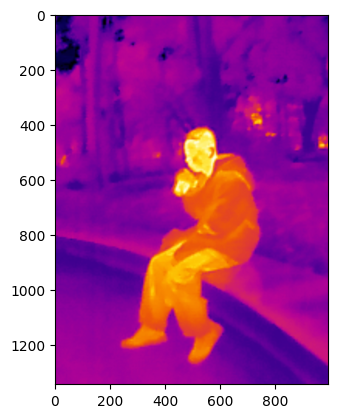

In [12]:
#取圖片高和寬
h, w = img.shape[:2]
# 浮水印佔據了底部96像素、右部88像素(配合32的倍數)
# 裁切語法：img[y_start:y_end, x_start:x_end]
cropped_img = img[0:h-96, 0:w-88]
#OpenCV 讀取圖片的預設格式是 BGR (藍、綠、紅)。
#Matplotlib 顯示圖片的預設格式是 RGB (紅、綠、藍)。
img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
# cv2.imshow("test", cropped_img)
# # 必須加上這行，否則視窗會立刻關閉。0 表示無限等待直到按下鍵盤任何鍵
# cv2.waitKey(0) 
# # 按下按鍵後，關閉所有 OpenCV 視窗
# cv2.destroyAllWindows()


In [13]:
#步驟一、轉為灰階

#轉為灰階後，後續去噪及局部增強較佳，且降低運算負擔
#cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

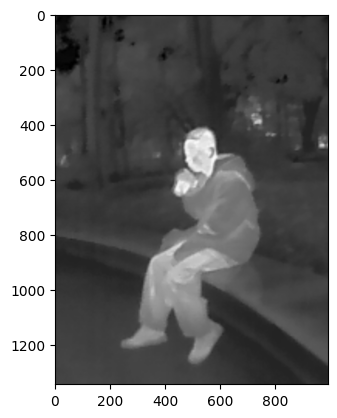

In [14]:
#步驟二、去噪(Denoising)處理

#熱顯像感測器容易產生「椒鹽雜訊」或固定圖案雜訊。先平滑化可以避免後續增強對比時把雜訊當成目標放大。
denoised_img = cv2.medianBlur(gray_img, 3)
# cv2.imshow("test", denoised_img)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()
img_rgb = cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [7]:
#消除雜訊： 在進行邊緣檢測（Edge Detection）或形態學運算（Morphology）之前，如果影像雜訊太多，會導致誤判，這時就會先用 medianBlur 清理影像。
#熱顯像鏡頭在某些環境下會產生明顯的熱噪點（Sensor noise），這些噪點可能會被誤認為是熱源。使用 medianBlur 可以有效過濾掉這些孤立的熱噪點，保留人體或目標物的大片熱特徵


#cv2.medianBlur(cropped_img, x)中值濾波（Median Filtering)函數
#第二個參數是濾波器的大小，必須是正奇數 (如 3, 5, 7)，設定得太小，雜訊去不掉；設定得太大，影像會變得過於模糊，甚至導致重要特徵消失。
"""
近距離檢查設備: 3 (影像清晰，只需去除細微電子雜訊，需保留設備零件的銳利邊緣。)
高空偵測人體(一般場景): 5 (兼顧去噪與輪廓保留，是大多數人的首選平衡點（如你程式中的設定）)。
惡劣天氣/高雜訊環境: 7 或 9 (畫面充滿雪花狀干擾，必須強力去噪，即使犧牲一點細節也要確保背景乾淨)。
"""

'\n近距離檢查設備: 3 (影像清晰，只需去除細微電子雜訊，需保留設備零件的銳利邊緣。)\n高空偵測人體(一般場景): 5 (兼顧去噪與輪廓保留，是大多數人的首選平衡點（如你程式中的設定）)。\n惡劣天氣/高雜訊環境: 7 或 9 (畫面充滿雪花狀干擾，必須強力去噪，即使犧牲一點細節也要確保背景乾淨)。\n'

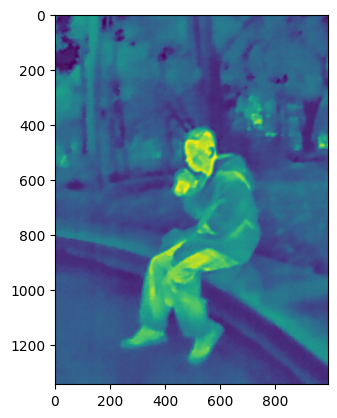

In [15]:
#步驟三、局部增強(Contrast Enhancement)處理

#熱顯像影像通常對比度較低，使用 CLAHE 可以提升
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(denoised_img)
plt.imshow(enhanced_img)

In [ ]:
#步驟四、尺寸縮放

#YOLO模型訓練過程照片尺寸要一致(卷積層要求輸入的張量（Tensor）形狀必須固定)，所以調整照片尺寸
#縮放原始影像(本次資料影像有統一可以省略)
#resized_img = cv2.resize(img, (640, 640), cv2.INTER_AREA)

In [ ]:
"""
2、常用的尺寸:較舊的YOLO使用正方形
YOLOv8/v10/v11也支援長方形輸入，只要長寬都是32的倍數即可
(因為 YOLO 的架構會進行 5 次下採樣（Downsampling，每次圖片尺寸減半），$2^5 = 32$。所以你的尺寸必須是 32 的倍數（如 320, 416, 640, 1280）)
"""
#cv2.resize(img, size(tuple), cv2.INTER_AREA)
"""
第三個參數:
 雙線性插值(預設) cv2.INTER_LINEAR
 縮小圖片用 cv2.INTER_AREA
 放大圖片用 cv2.INTER_CUBIC
 快速處理(有明顯階梯狀（鋸齒）) cv2.INTER_NEAREST
 """

In [16]:
#步驟五、標準化/顯示(Normalization)

dst = cv2.normalize(enhanced_img, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

In [ ]:
"""cv2.normalize(enhanced_img, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
第一個參數:輸入影像(enhanced_img)

第二個參數:輸出影像(通常設為 None，表示自動創建一個新的輸出影像)

第三個參數:輸出影像的最小值 (這裡設為 0)
0：配合 NORM_MINMAX 使用，作為縮放後的最小值
1：配合 NORM_L2 或 NORM_L1 使用，表示將整個矩陣縮放至長度為 1 的單位向量

第四個參數:輸出影像的最大值 (這裡設為 1)（僅在 NORM_MINMAX 模式下生效）
1：適合將像素值轉化為 $0 \sim 1$ 的浮點數（YOLO 模型標準輸入）。
255：適合將資料拉開後，重新存回 8-bit 影像格式（人眼觀察或存檔）。

第五個參數:歸一化類型 (這裡使用 NORM_MINMAX，表示將數值線性映射到指定範圍)
cv2.NORM_MINMAX:線性縮放，公式為：max−minx−min​⋅(β−α)+α,影像顯示與 YOLO 輸入：這是最直觀的縮放，保留了像素間的線性比例關係，不會扭曲原始特徵。
cv2.NORM_L2:歐幾里得範數（向量長度為 1）,特徵比對：在計算圖片特徵點（如 SIFT/ORB）的相似度時使用，理由是消除亮度對向量長度的影響。
cv2.NORM_L1:絕對值之和為 1,機率分布分析：若將影像像素視為機率分布時使用，確保所有像素加總為 1。
cv2.NORM_INF:最大絕對值為 1,異常值檢測：僅由矩陣中最大的那個數字來決定縮放比例。

第六個參數:輸出影像的資料類型 (這裡使用 CV_32F，表示 32 位元浮點數)
cv2.CV_32F (float32) 理由：0 到 1 之間有無窮多個小數，必須用浮點數才能精確保存，否則資訊會遺失。
cv2.CV_8U (uint8)    理由：這是標準影像格式，節省空間且可直接透過 cv2.imshow 顯示
-1  理由：自動繼承，減少手動設定錯誤
"""

In [17]:
file_name = "preprocessed_images_2.jpg"
output_folder = "preprocessed_images"
save_path = os.path.join(output_folder, file_name)
cv2.imwrite(save_path, enhanced_img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

True